In [ ]:
!pip install contractions
!pip install fuzzywuzzy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , confusion_matrix

import contractions

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/quara duplicate questions pair.csv')
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df.dropna(inplace = True)

In [ ]:
df = df.sample(10000,random_state = 26)[['question1',	'question2',	'is_duplicate']]

# using full dataset
# df = df[['question1' , 'question2' , 'is_duplicate']]
df.shape

(10000, 3)

<Axes: ylabel='count'>

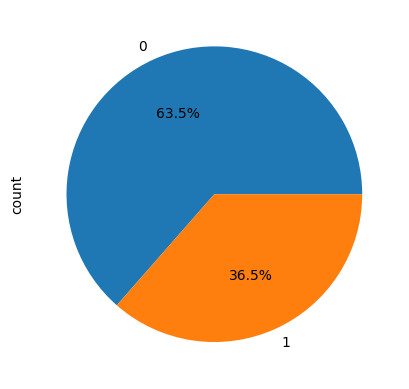

In [ ]:
df['is_duplicate'].value_counts().plot(kind = 'pie' , autopct = '%0.1f%%')

data is **Imbalanced**

# expanding short words   
like what's --> what is  
i'm --> i am


In [ ]:
contractions.fix("i'm a boy. and i'll go markete,")

'i am a boy. and i will go markete,'

In [ ]:
df['question1'].iloc[0]

"What's the difference between dopamine, serotonin, oxytocin, and endorphins?"

In [ ]:
df['question1'] = df['question1'].apply(lambda text : contractions.fix(text))
df['question2'] = df['question2'].apply(lambda text : contractions.fix(text))

# Text Preprocessing

In [ ]:
all_q = pd.Series(df['question1'].tolist() + df['question2'].tolist(),name = 'question' )
all_q.shape

(20000,)

In [ ]:
all_q.head()

,question
0,"What is the difference between dopamine, serot..."
1,How come nobody is answering my questions in Q...
2,How can I earn money online easily?
3,How can you describe the process of impeachment?
4,How to wash hair to stop hair fall?


### Lowercasing and white spaces

In [ ]:
all_q = all_q.str.lower().str.strip()

### Removing HTML tags

In [ ]:
all_q = all_q.apply(lambda x : re.sub('<.*?>' , '' , x))

In [ ]:
all_q.head(1)

,question
0,"what is the difference between dopamine, serot..."


In [ ]:
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()

In [ ]:
df.head()

,question1,question2,is_duplicate
50312,"what is the difference between dopamine, serot...","i smoke marijuana. morality aside, my antipsyc...",0
69455,how come nobody is answering my questions in q...,why do all of my questions get ignored on quora?,1
10374,how can i earn money online easily?,what are the easiest ways to earn money online?,1
227272,how can you describe the process of impeachment?,how can you describe the process of impeachement?,1
48260,how to wash hair to stop hair fall?,what is the best treatment for hair loss?,0


# Creating Custom Features

In [ ]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [ ]:
df['q1_words'] = df['question1'].apply(lambda text : len(text.split(" ")) )
df['q2_words'] = df['question2'].apply(lambda text : len(text.split(" ")) )

In [ ]:
def word_common(row):
  word1 = set(row['question1'].split(" "))
  word2 = set(row['question2'].split(" "))

  return len(word1.intersection(word2))

In [ ]:
df['common_words'] = df.apply(word_common ,axis = 1)

In [ ]:
df['word total'] = df['q1_len'] + df['q2_len']

In [ ]:
df['word share'] = df['common_words'] / df['word total']

In [ ]:
stop_words = stopwords.words('english')

def find_word_tokenize(text):
  stop_words = stopwords.words('english')

  words = word_tokenize(text)

  return len([word for word in words if word in stop_words])

In [ ]:
df['q1_stopwords'] = df['question1'].apply(find_word_tokenize)
df['q2_stopwords'] = df['question2'].apply(find_word_tokenize)

In [ ]:
df.head(2)

,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords
50312,"what is the difference between dopamine, serot...","i smoke marijuana. morality aside, my antipsyc...",0,77,148,10,21,2,225,0.008889,5,8
69455,how come nobody is answering my questions in q...,why do all of my questions get ignored on quora?,1,51,48,9,10,3,99,0.030303,4,6


<Axes: ylabel='Frequency'>

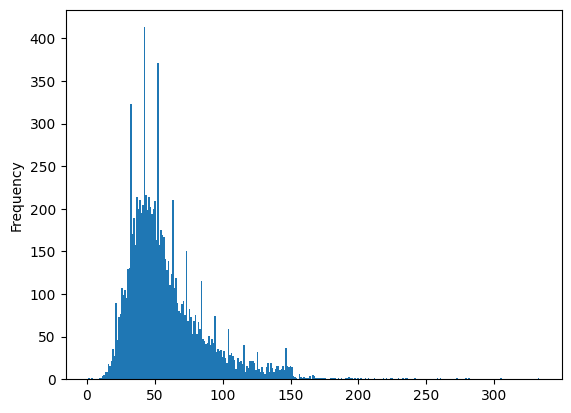

In [ ]:
df['q1_len'].plot(kind = 'hist' , bins = 300)

<Axes: ylabel='Frequency'>

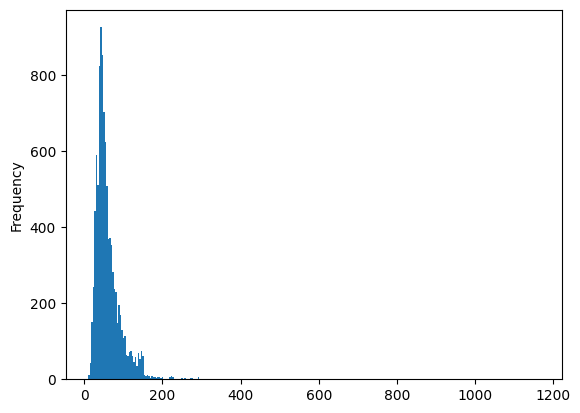

In [ ]:
df['q2_len'].plot(kind = 'hist',bins = 300)

<Axes: ylabel='Frequency'>

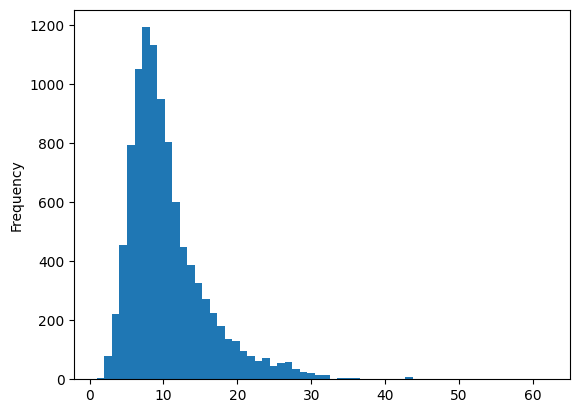

In [ ]:
df['q1_words'].plot(kind = 'hist',bins = 60)

<Axes: ylabel='Frequency'>

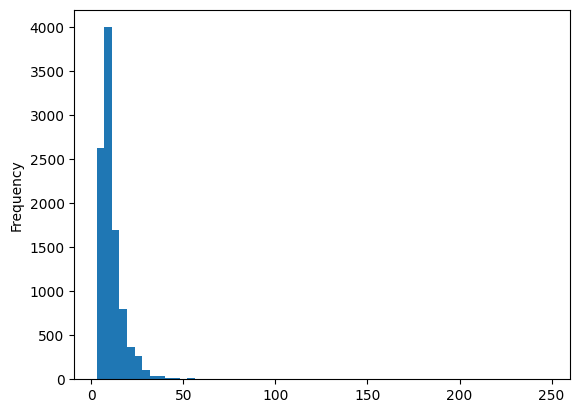

In [ ]:
df['q2_words'].plot(kind = 'hist' , bins = 60)

<Axes: ylabel='Frequency'>

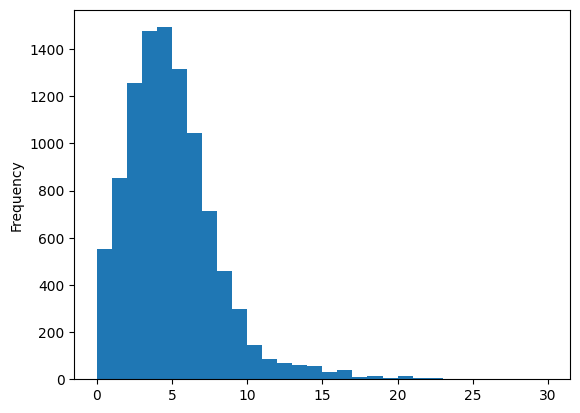

In [ ]:
df['common_words'].plot(kind = 'hist',bins = 30)

<Axes: ylabel='Frequency'>

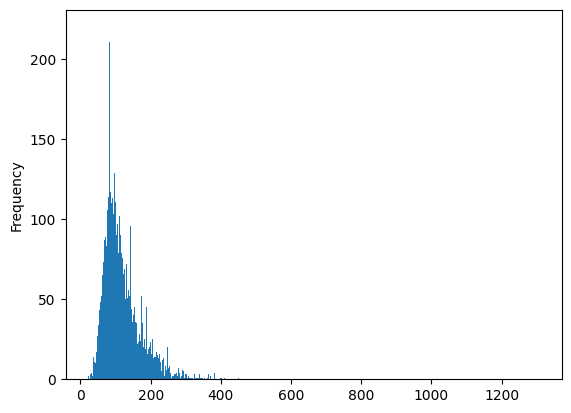

In [ ]:
df['word total'].plot(kind = 'hist', bins = 1200)

<Axes: ylabel='Frequency'>

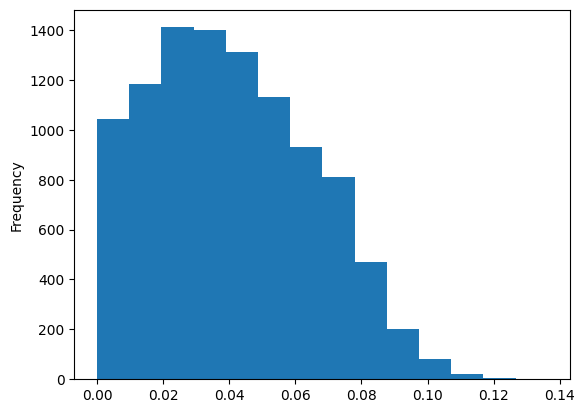

In [ ]:
df['word share'].plot(kind = 'hist' , bins =14 )

<Axes: ylabel='Frequency'>

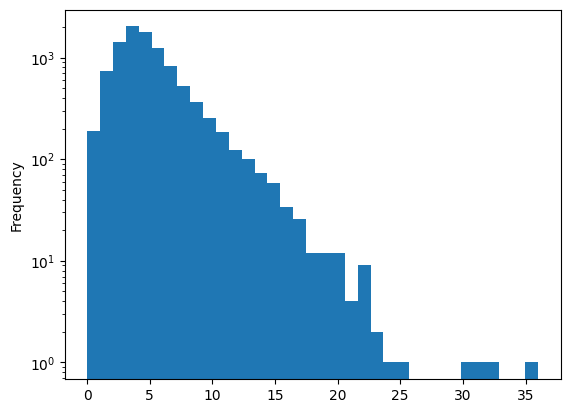

In [ ]:
df['q1_stopwords'].plot(kind = 'hist' , log=True , bins = 35)

<Axes: ylabel='Frequency'>

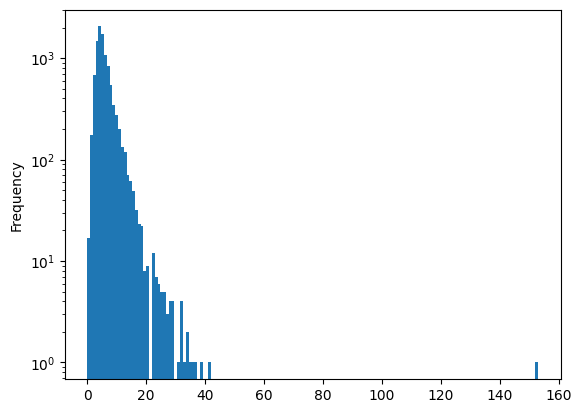

In [ ]:
df['q2_stopwords'].plot(kind = 'hist' , log = True , bins = 160)

<ipython-input-66-2130212efd18>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q1_len'],label='non duplicate')
<ipython-input-66-2130212efd18>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q1_len'],label='duplicate')


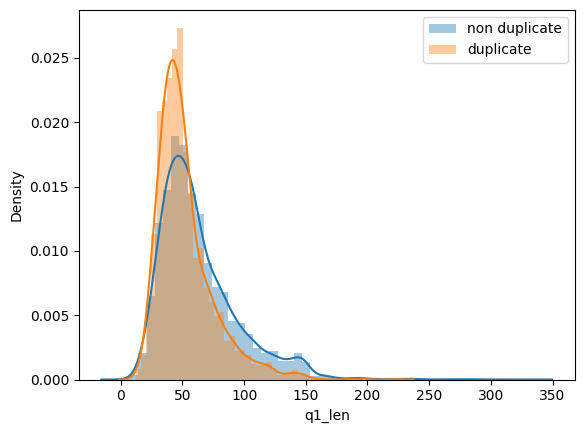

In [ ]:
# question 1 length
sns.distplot(df[df['is_duplicate'] == 0]['q1_len'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q1_len'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-67-a8ee4ef86212>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q2_len'],label='non duplicate')
<ipython-input-67-a8ee4ef86212>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q2_len'],label='duplicate')


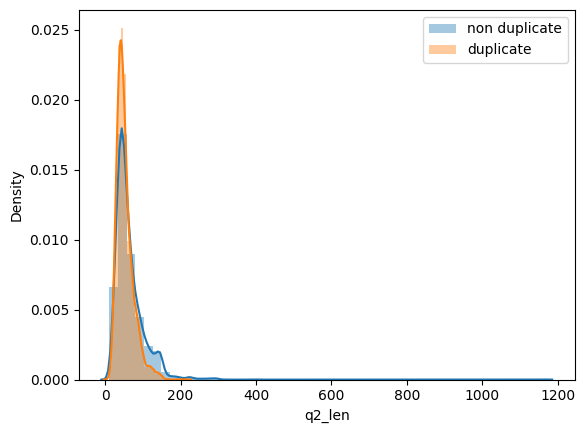

In [ ]:
# question 2 length
sns.distplot(df[df['is_duplicate'] == 0]['q2_len'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q2_len'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-68-e3b671603ed2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q1_words'],label='non duplicate')
<ipython-input-68-e3b671603ed2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q1_words'],label='duplicate')


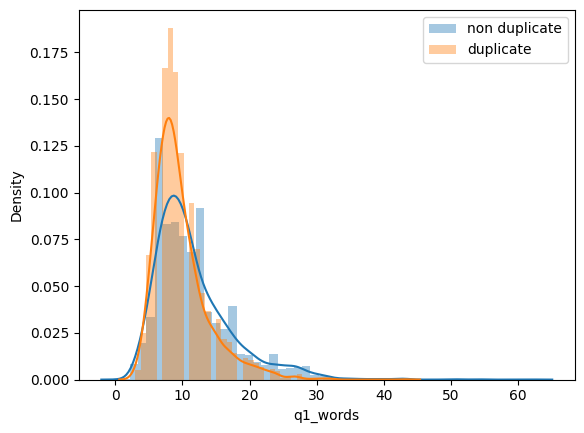

In [ ]:
# question 1 words
sns.distplot(df[df['is_duplicate'] == 0]['q1_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q1_words'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-69-ade65a244475>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q2_words'],label='non duplicate')
<ipython-input-69-ade65a244475>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q2_words'],label='duplicate')


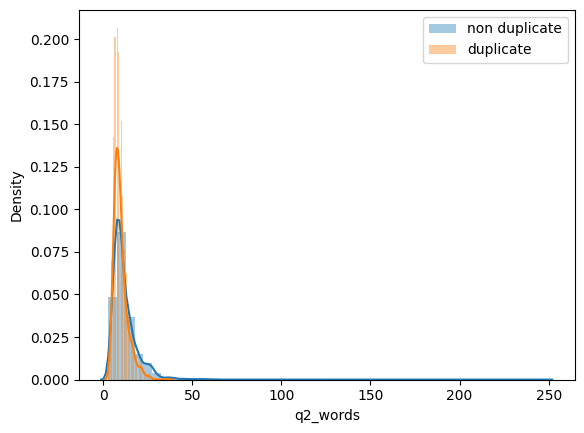

In [ ]:
# question 2 words
sns.distplot(df[df['is_duplicate'] == 0]['q2_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q2_words'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-70-9fbba4a7cb89>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['common_words'],label='non duplicate')
<ipython-input-70-9fbba4a7cb89>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['common_words'],label='duplicate')


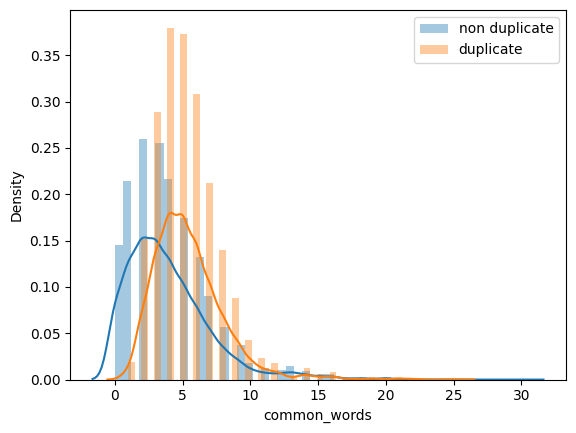

In [ ]:
# common words
sns.distplot(df[df['is_duplicate'] == 0]['common_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['common_words'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-71-317202ea3b33>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['word total'],label='non duplicate')
<ipython-input-71-317202ea3b33>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['word total'],label='duplicate')


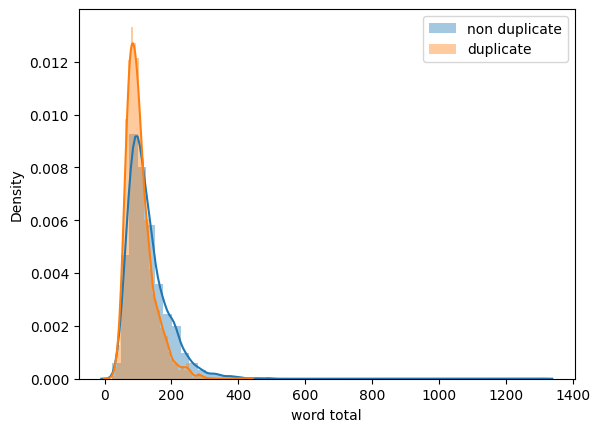

In [ ]:
# total words
sns.distplot(df[df['is_duplicate'] == 0]['word total'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word total'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-72-3181b98bf72a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['word share'],label='non duplicate')
<ipython-input-72-3181b98bf72a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['word share'],label='duplicate')


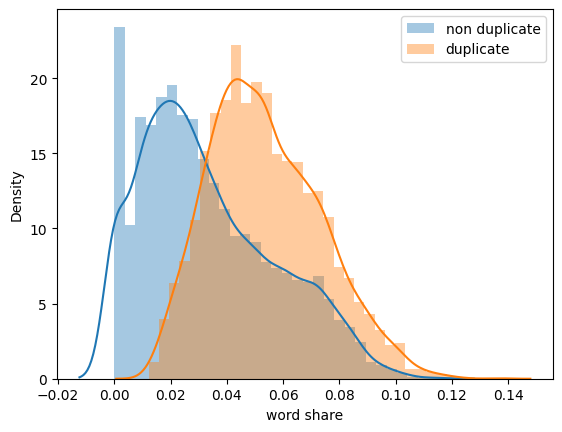

In [ ]:
# word share
sns.distplot(df[df['is_duplicate'] == 0]['word share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word share'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-73-66103a22b2da>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q1_stopwords'],label='non duplicate')
<ipython-input-73-66103a22b2da>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q1_stopwords'],label='duplicate')


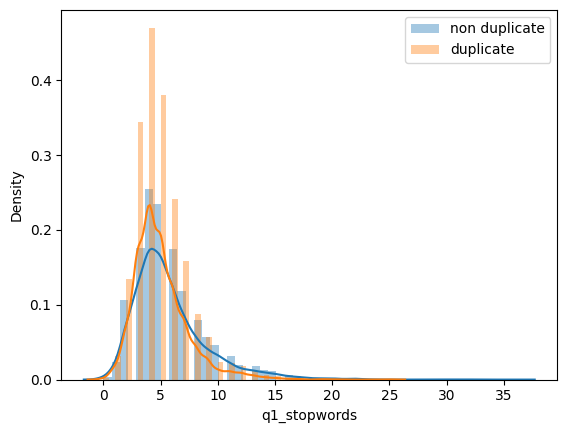

In [ ]:
# question 1 stop words
sns.distplot(df[df['is_duplicate'] == 0]['q1_stopwords'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q1_stopwords'],label='duplicate')
plt.legend()
plt.show()

<ipython-input-74-00b60b0f2515>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 0]['q2_stopwords'],label='non duplicate')
<ipython-input-74-00b60b0f2515>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1]['q2_stopwords'],label='duplicate')


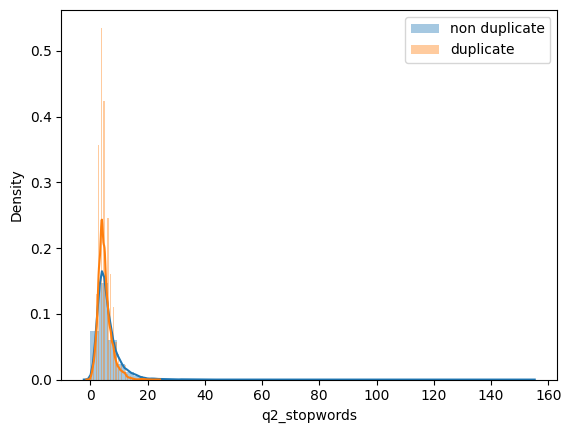

In [ ]:
# question 2 stop words
sns.distplot(df[df['is_duplicate'] == 0]['q2_stopwords'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['q2_stopwords'],label='duplicate')
plt.legend()
plt.show()

<p color = 'green' > after creating some custom features we got 2.3% of accuracy score improvement ,  
Now it become 74.35%

## token Features

#  Advanced Features
## 1. Token Features
- `cwc_min` : This is the ratio of the number of common words to the length of the smaller question

- `cwc_max` : This is the ratio of the number of common words to the length of the larger question  

- `csc_min` : This is the ratio of the number of common stop words to the smaller stop word count among the two questions  

- `csc_max` : This is the ratio of the number of common stop words to the larger stop word count among the two questions  

- `ctc_min`: This is the ratio of the number of common tokens to the smaller token count among the two questions  

- `ctc_max` : This is the ratio of the number of common tokens to the larger token count among the two questions  

- `last_word_eq`: 1 if the last word in the two questions is same, 0 otherwise  

- `first_word_eq`: 1 if the first word in the two questions is same, 0 otherwise  

## 2. Length Based Features
- `mean_len`: Mean of the length of the two questions (number of words)  

- `abs_len_diff`: Absolute difference between the length of the two questions (number of words)  

- `longest_substr_ratio`: Ratio of the length of the longest substring among the two questions to the length of the smaller question  

## 3. Fuzzy Features
- `fuzz_ratio`: fuzz_ratio score from fuzzywuzzy  

- `fuzz_partial_ratio`: fuzz_partial_ratio from fuzzywuzzy  

- `token_sort_ratio:` token_sort_ratio from fuzzywuzzy  

- `token_set_ratio`: token_set_ratio from fuzzywuzzy

## Token features

In [ ]:
def find_cwc_min(row):
  return row['common_words'] / min(row['q1_words'] , row['q2_words'])

In [ ]:
df['cwc_min'] = df.apply(find_cwc_min ,axis = 1)

In [ ]:
def find_cwc_max(row):
  return row['common_words'] / max(row['q1_words'] , row['q2_words'])

In [ ]:
df['cwc_max'] = df.apply(find_cwc_max, axis = 1)

In [ ]:
def find_csc_min(row):
  return row['common_words'] / (min(row['q1_stopwords'] , row['q2_stopwords']) + 0.000001)

In [ ]:
df['csc_min'] = df.apply(find_csc_min , axis = 1)

In [ ]:
def find_csc_max(row):
  return row['common_words'] / (max(row['q1_stopwords'] , row['q2_stopwords']) + 0.000001)

In [ ]:
df['csc_max'] = df.apply(find_csc_max , axis = 1)

In [ ]:
def find_ctc_min(row):
  return row['common_words'] / min(row['q1_len'] , row['q2_len'])

In [ ]:
df['ctc_min'] = df.apply(find_ctc_min , axis = 1)

In [ ]:
def find_ctc_max(row):
  return row['common_words'] / max(row['q1_len'] , row['q2_len'])

In [ ]:
df['ctc_max'] = df.apply(find_ctc_max , axis = 1)

In [ ]:
def find_first_word_equal(row):
  return 1 if row['question1'].split(" ")[0] == row ['question2'].split(" ")[0] else 0

In [ ]:
df['first_word_eq'] = df.apply(find_first_word_equal , axis = 1)

In [ ]:
def find_last_word_equal(row):
  return 1 if row['question1'].split(" ")[-1] == row ['question2'].split(" ")[-1] else 0

In [ ]:
df['last_word_eq'] = df.apply(find_last_word_equal , axis = 1)

In [ ]:
df.head(2)

,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq
50312,"what is the difference between dopamine, serot...","i smoke marijuana. morality aside, my antipsyc...",0,77,148,10,21,2,225,0.008889,5,8,0.025974,0.013514,0.40,0.25,0.025974,0.013514,0,0
69455,how come nobody is answering my questions in q...,why do all of my questions get ignored on quora?,1,51,48,9,10,3,99,0.030303,4,6,0.062500,0.058824,0.75,0.50,0.062500,0.058824,0,1


<Axes: ylabel='Frequency'>

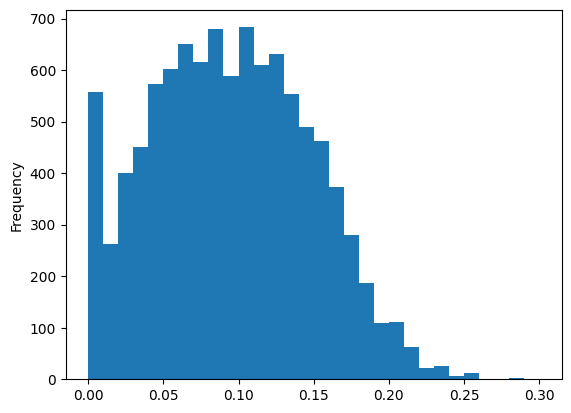

In [ ]:
df['cwc_min'].plot(kind = 'hist' , bins = 30)

<Axes: ylabel='Frequency'>

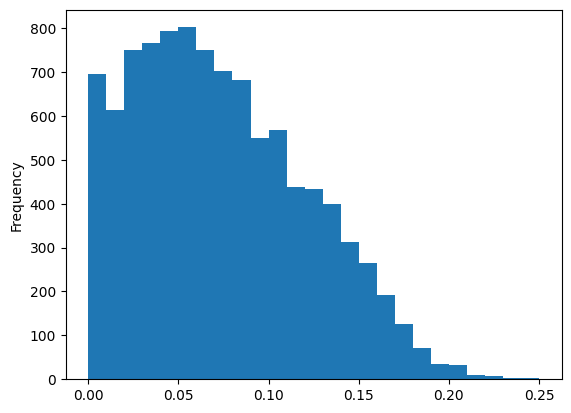

In [ ]:
df['cwc_max'].plot(kind = 'hist' , bins = 25)

<Axes: ylabel='Frequency'>

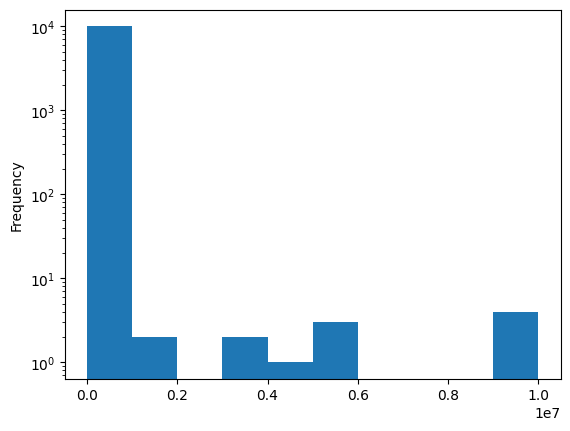

In [ ]:
df['csc_min'].plot(kind = 'hist',log= True,bins = 10)

<Axes: ylabel='Frequency'>

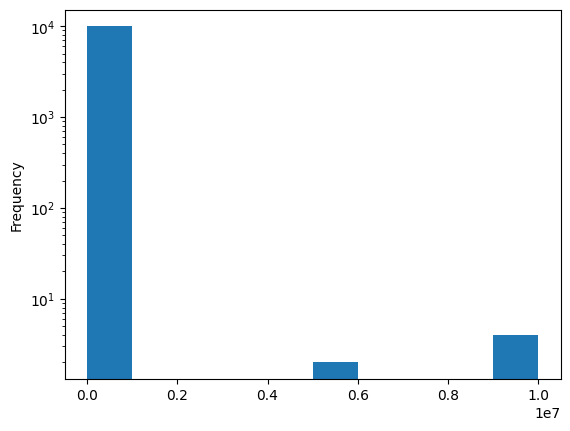

In [ ]:
df['csc_max'].plot(kind = 'hist',log = True, bins = 10)

<Axes: ylabel='Frequency'>

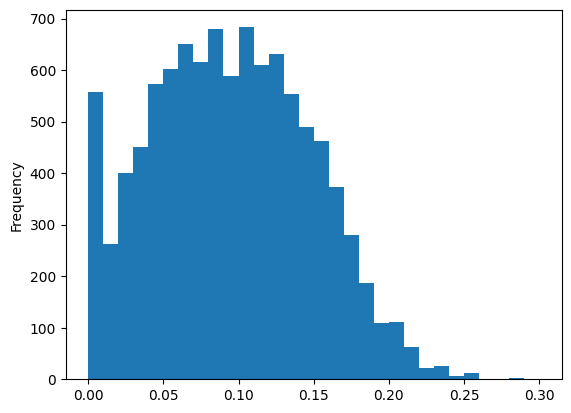

In [ ]:
df['ctc_min'].plot(kind='hist' , bins = 30)

<Axes: ylabel='Frequency'>

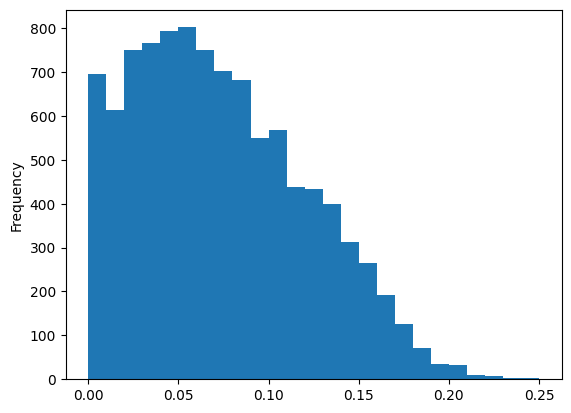

In [ ]:
df['ctc_max'].plot(kind = 'hist' , bins = 25)

**almost all features are in RIGHT skewed , so normize**

<Axes: ylabel='count'>

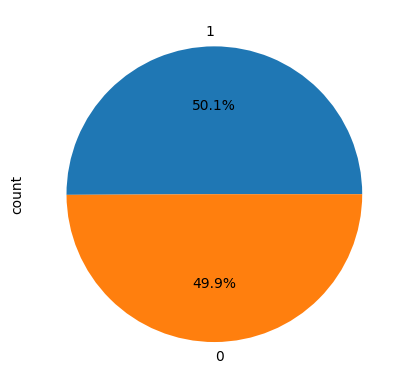

In [ ]:
df['first_word_eq'].value_counts().plot(kind = 'pie' , autopct = '%0.1f%%')

<Axes: ylabel='count'>

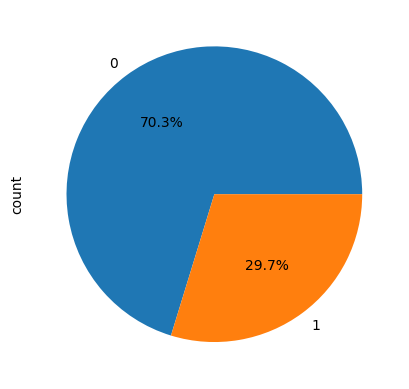

In [ ]:
df['last_word_eq'].value_counts().plot(kind = 'pie' , autopct = '%0.1f%%')

## Length based feature

In [ ]:
df['mean_len'] = (df['q1_words'] + df['q2_words']) / 2

In [ ]:
df['abs_len_diff'] = abs(df['q1_words'] - df['q2_words'])

<Axes: ylabel='Frequency'>

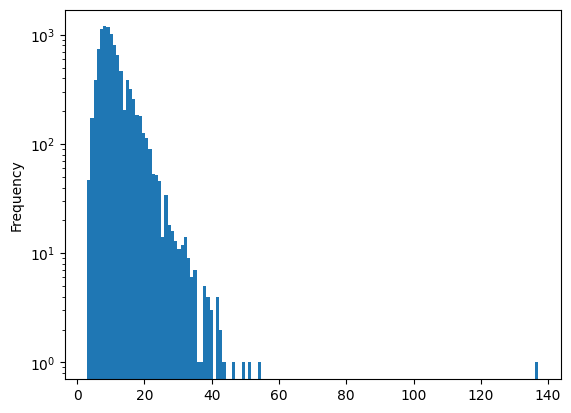

In [ ]:
df['mean_len'].plot(kind = 'hist' , log = True , bins = 140)

<Axes: ylabel='Frequency'>

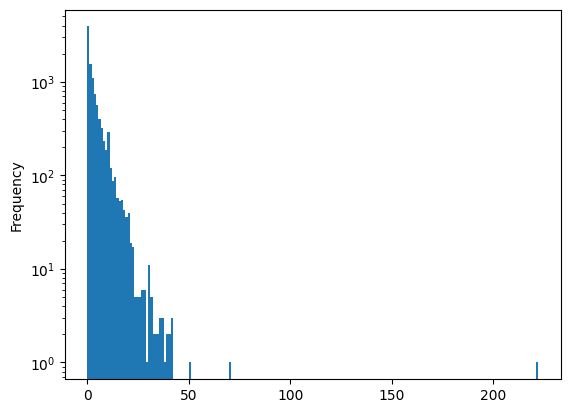

In [ ]:
df['abs_len_diff'].plot(kind = 'hist' , log = True , bins = 200)

**right skewed**

## fuzzywuzzy features

fuzzywuzzy reference link : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))
df.shape

(10000, 26)

In [ ]:
df.head(1)

,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,mean_len,abs_len_diff
50312,"what is the difference between dopamine, serot...","i smoke marijuana. morality aside, my antipsyc...",0,77,148,10,21,2,225,0.008889,...,0.025974,0.013514,0.4,0.25,0.025974,0.013514,0,0,15.5,11


#### Normalization

In [ ]:
df.columns[2:]

Index(['is_duplicate', 'q1_len', 'q2_len', 'q1_words', 'q2_words',
       'common_words', 'word total', 'word share', 'q1_stopwords',
       'q2_stopwords', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'first_word_eq', 'last_word_eq', 'mean_len', 'abs_len_diff'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_scaler = MinMaxScaler()

scaled_values = min_scaler.fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
scaled_values

array([[8.65800866e-02, 5.40540541e-02, 3.99999920e-08, ...,
        3.90000000e-01, 3.00000000e-01, 2.79069767e-01],
       [2.08333333e-01, 2.35294118e-01, 7.49999813e-08, ...,
        5.40000000e-01, 5.60000000e-01, 5.58139535e-01],
       [1.90476190e-01, 1.70212766e-01, 6.66666444e-08, ...,
        6.00000000e-01, 5.00000000e-01, 6.62790698e-01],
       ...,
       [4.16666667e-01, 4.44444444e-01, 1.24999969e-07, ...,
        9.40000000e-01, 7.00000000e-01, 5.69767442e-01],
       [5.67375887e-01, 5.92592593e-01, 1.33333311e-07, ...,
        8.40000000e-01, 8.10000000e-01, 8.60465116e-01],
       [4.61538462e-01, 3.56435644e-01, 1.79999964e-07, ...,
        6.30000000e-01, 7.00000000e-01, 6.27906977e-01]])

In [ ]:
scaled_values.shape

(10000, 14)

In [ ]:
scale_df = pd.DataFrame(scaled_values , index = df.index , columns = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio'])
scale_df.shape

(10000, 14)

In [ ]:
scale_df.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
50312,0.08658,0.054054,3.999999e-08,2.500000e-08,0.08658,0.054054,0.0,0.0,0.04955,0.093284,0.53,0.39,0.3,0.27907


In [ ]:
new_df = pd.merge(df[['is_duplicate', 'q1_len', 'q2_len', 'q1_words', 'q2_words','common_words', 'word total', 'word share', 'q1_stopwords','q2_stopwords']] , scale_df , left_index = True , right_index = True)
new_df.shape

(10000, 24)

In [ ]:
new_df.head(1)

,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
50312,0,77,148,10,21,2,225,0.008889,5,8,...,0.08658,0.054054,0.0,0.0,0.04955,0.093284,0.53,0.39,0.3,0.27907


# Text Representation

## Bag Of Word (BOW)

In [ ]:
cv = CountVectorizer(max_features = 3500 , binary=True)
bow = cv.fit_transform(all_q).toarray()
bow.shape

(20000, 3500)

In [ ]:
bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
bow_df = pd.DataFrame(np.hstack((bow[:10000] , bow[10000:])) , index = df.index)
print(bow_df.shape)
bow_df.head()

(10000, 7000)


,0,1,2,3,4,5,6,7,8,9,...,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999
50312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
final_df = pd.merge(new_df , bow_df ,left_index = True , right_index = True)
final_df.shape

(10000, 7024)

In [ ]:
final_df.head(1)

,is_duplicate,q1_len,q2_len,q1_words,q2_words,common_words,word total,word share,q1_stopwords,q2_stopwords,...,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999
50312,0,77,148,10,21,2,225,0.008889,5,8,...,0,0,0,0,0,0,0,0,0,0


## Random Forest

In [ ]:
# to conert all the columns names (int to str)
final_df.columns = final_df.columns.astype('str')

In [ ]:
x = final_df.iloc[: , 1:]
y = final_df.iloc[:,0]
x_train , x_test , y_train , y_test = train_test_split(x, y  , test_size = 0.2 , random_state = 2)

rf = RandomForestClassifier()
rf.fit(x_train , y_train)

print(accuracy_score(y_test , rf.predict(x_test)))
print(confusion_matrix(y_test , rf.predict(x_test)) , end = '\n\n')

0.7715
[[1068  176]
 [ 281  475]]



In [ ]:
import pickle
pickle.dump(cv,open('cv.pkl' , 'wb'))
pickle.dump(rf,open('rf.pkl' , 'wb'))

In [ ]:
pickle.dump(min_scaler,open('scaler.pkl' , 'wb'))

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train , y_train)

print(accuracy_score(y_test , log_reg.predict(x_test)))
print(confusion_matrix(y_test , log_reg.predict(x_test)) , end = '\n\n')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7425
[[1064  180]
 [ 335  421]]



## GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train , y_train)

print(accuracy_score(y_test , nb.predict(x_test)))
print(confusion_matrix(y_test , nb.predict(x_test)) , end = '\n\n')

0.622
[[684 560]
 [196 560]]



## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train , y_train)

print(accuracy_score(y_test , knn.predict(x_test)))
print(confusion_matrix(y_test , knn.predict(x_test)) , end = '\n\n')

0.6735
[[1000  244]
 [ 409  347]]



## Xg Boost classifier

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(x_train , y_train)

print(accuracy_score(y_test , xgb_clf.predict(x_test)))
print(confusion_matrix(y_test , xgb_clf.predict(x_test)) , end = '\n\n')

0.776
[[1039  205]
 [ 243  513]]



## I'm choosing RandomForest model because it has less type II Error and more accuracy

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

print(accuracy_score(y_test , rf.predict(x_test)))
print(confusion_matrix(y_test , rf.predict(x_test)) , end = '\n\n')

0.7645
[[1066  178]
 [ 293  463]]



In [ ]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
cv_scores = cross_val_score(rf, x, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())

Cross-validation scores:  [0.773  0.7715 0.7755 0.7825 0.752 ]
Mean cross-validation score:  0.7708999999999999


In [ ]:
for i in [3500,4000]:
  cv = CountVectorizer(max_features = i , binary=True)
  bow = cv.fit_transform(all_q).toarray()

  bow_df = pd.DataFrame(np.hstack((bow[:df.shape[0]] , bow[df.shape[0]:])) , index = df.index)

  final_df = pd.merge(new_df , bow_df ,left_index = True , right_index = True)

  final_df.columns = final_df.columns.astype('str')

  x = final_df.iloc[: , 1:]
  y = final_df.iloc[:,0]
  x_train , x_test , y_train , y_test = train_test_split(x, y  , test_size = 0.2 , random_state = 2)

  rf = RandomForestClassifier(
                        n_estimators=100,          # 100 trees in the forest
                        max_depth=10,              # Trees can grow to a maximum depth of 10
                        min_samples_split=5,       # A node must have at least 5 samples to be split
                        min_samples_leaf=5,        # A leaf must have at least 2 samples
                        max_features='sqrt',       # Consider the square root of total features when splitting
                        bootstrap=True,            # Use bootstrap samples
                        oob_score=True,            # Use out-of-bag samples for evaluation
                        random_state=42,           # Set seed for reproducibility
                        class_weight='balanced',
                        n_jobs=-1                  # Use all available cores for parallelism
  )

  rf.fit(x_train , y_train)

  print(f'features : {i}')
  print(accuracy_score(y_test , rf.predict(x_test)))
  print(confusion_matrix(y_test , rf.predict(x_test)) , end = '\n\n')

features : 3500
0.697
[[741 503]
 [103 653]]

features : 4000
0.708
[[757 487]
 [ 97 659]]



In [ ]:
final_df.shape

(10000, 8024)